In [6]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
root_directory = '/data/szucca/'
experiment = 'Nicole'
experimental_group = 'Black_wf_WholeBrain'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]

In [12]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/user/.conda/envs/ClearMap/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [19]:
def load_subject(subject, data_directory, threshold):
    file_suffix = 'cells_' + str(threshold)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

# Analysis on Black with father Whole Brain

In [21]:
#dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject, 
#                                                                                                data_directory=data_directory,
#                                                                                               threshold=2500), 
#                                                                          vol=volumes, 
#                                                                          level=8) for subject in subjects}
#np.save('dict_results/dict_results_across_mice_Black_wf_WholeBrain.npy', dict_results_across_mice)

/home/user/.conda/envs/ClearMap/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  """
/home/user/.conda/envs/ClearMap/lib/python3.7/site-packages/ipykernel_launcher.py:5: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  """


In [22]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_Black_wf_WholeBrain.npy', 
                                   allow_pickle=True).item()

In [23]:
subjects = list(dict_results_across_mice.keys())

# List areas with null cell count

In [24]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [25]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [26]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['BL45Control', 'BL53Control', 'BL51Control'],
 'Fam': ['BL49Fam', 'BL50Fam', 'BL47Fam'],
 'Unfam': ['BL48Unfam', 'BL46Unfam', 'BL54Unfam', 'BL52Unfam']}

# Calculate cell count across experimental groups

In [30]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

# Total number of cells

In [110]:
df_control_cell_count.set_index('area').sum()

BL45Control    164456
BL53Control    101102
BL51Control    234914
dtype: int64

In [111]:
df_fam_cell_count.set_index('area').sum()

BL49Fam    145085
BL50Fam    161343
BL47Fam    213989
dtype: int64

In [112]:
df_unfam_cell_count.set_index('area').sum()

BL48Unfam    193231
BL46Unfam     78504
BL54Unfam    116642
BL52Unfam     78038
dtype: int64

# Look at cell count per area

In [127]:
df_control_cell_count.set_index('area').loc['Medial amygdalar nucleus']

BL45Control     826
BL53Control     460
BL51Control    1221
Name: Medial amygdalar nucleus, dtype: int64

In [128]:
df_fam_cell_count.set_index('area').loc['Medial amygdalar nucleus']

BL49Fam     767
BL50Fam    2470
BL47Fam    3516
Name: Medial amygdalar nucleus, dtype: int64

In [129]:
df_unfam_cell_count.set_index('area').loc['Medial amygdalar nucleus']

BL48Unfam    2024
BL46Unfam     991
BL54Unfam    1478
BL52Unfam     614
Name: Medial amygdalar nucleus, dtype: int64

In [102]:
df_control_cell_count.set_index('area').loc['Ventral premammillary nucleus']

BL45Control    15
BL53Control    13
BL51Control    14
Name: Ventral premammillary nucleus, dtype: int64

In [103]:
df_fam_cell_count.set_index('area').loc['Ventral premammillary nucleus']

BL49Fam     21
BL50Fam    389
BL47Fam    549
Name: Ventral premammillary nucleus, dtype: int64

In [104]:
df_unfam_cell_count.set_index('area').loc['Ventral premammillary nucleus']

BL48Unfam    246
BL46Unfam    107
BL54Unfam    241
BL52Unfam    149
Name: Ventral premammillary nucleus, dtype: int64

## Calculate t-tests across groups per area

In [32]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])

In [33]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:10].set_index('area')

,pval_Control_vs_Fam
area,
Basomedial amygdalar nucleus,0.024818
Piriform-amygdalar area,0.041679
Anterodorsal preoptic nucleus,0.042846
Ventromedial hypothalamic nucleus,0.051546
Intercalated amygdalar nucleus,0.055005
Subparaventricular zone,0.060812
Cortical amygdalar area,0.071686
Subthalamic nucleus,0.075322
Periventricular hypothalamic nucleus preoptic part,0.101753


In [101]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']].set_index('area').loc['Supramammillary nucleus']

pval_Control_vs_Fam    0.339234
Name: Supramammillary nucleus, dtype: object

In [38]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.008374
Parafascicular nucleus,0.019526
Subthalamic nucleus,0.02172
Vascular organ of the lamina terminalis,0.023574
Taenia tecta,0.024208
Piriform-amygdalar area,0.028915
Cortical amygdalar area,0.030379
Medial septal complex,0.031857
Anterior hypothalamic nucleus,0.04523


In [100]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']].set_index('area').loc['Supramammillary nucleus']

pval_Control_vs_Unfam    0.372112
Name: Supramammillary nucleus, dtype: object

In [47]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:35].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterodorsal preoptic nucleus,0.000148
Medial septal complex,0.002259
Paraventricular hypothalamic nucleus,0.004649
Anterodorsal nucleus,0.006572
Nucleus of reuniens,0.006845
Mediodorsal nucleus of thalamus,0.007621
Anterior hypothalamic nucleus,0.012123
Superior colliculus motor related,0.012515
Subparaventricular zone,0.014175


In [99]:
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']].set_index('area').loc['Supramammillary nucleus']

pval_Fam_vs_Unfam    0.083113
Name: Supramammillary nucleus, dtype: object

## Calculate cross corr across groups per area on cell count

In [65]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)

In [66]:
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)

In [67]:
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

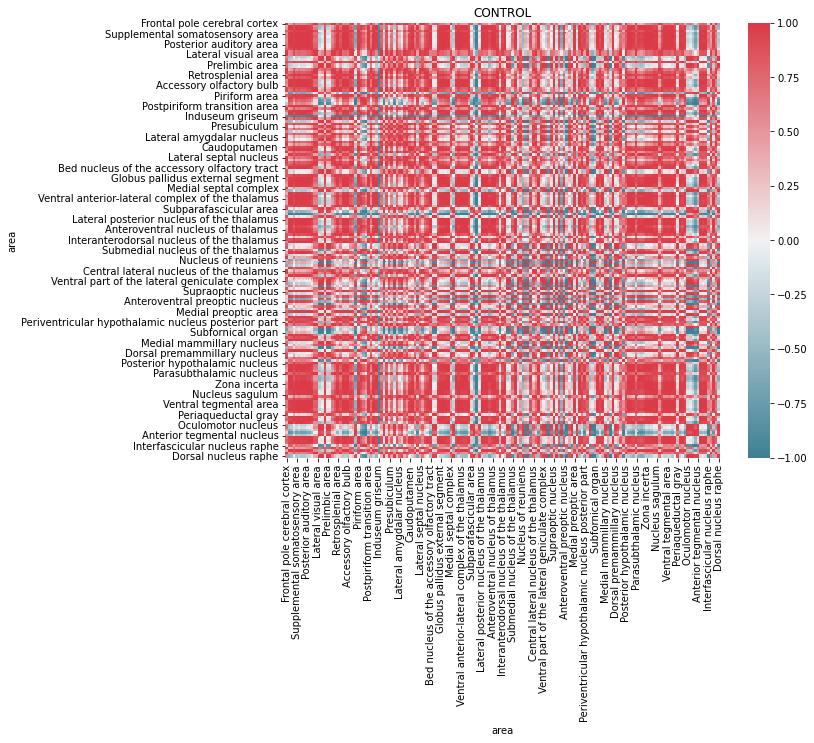

In [68]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

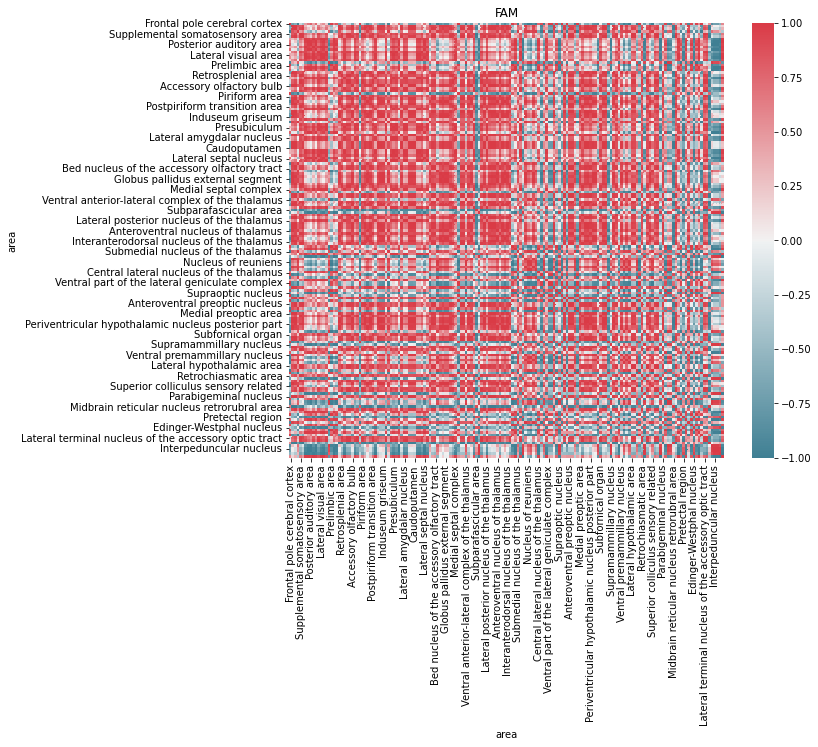

In [69]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

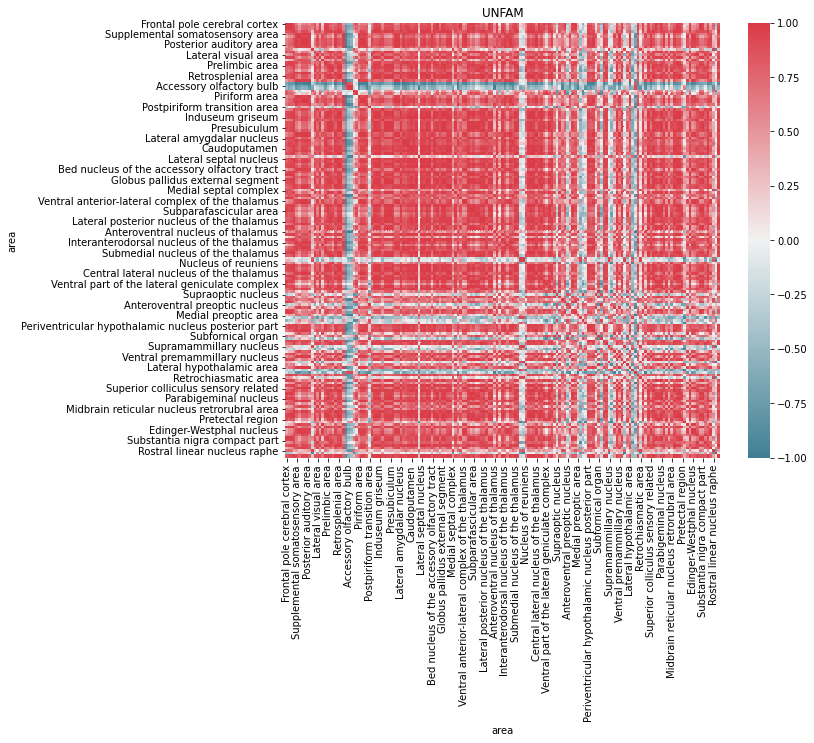

In [70]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [83]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [84]:
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])

In [85]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [87]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:10].set_index('area')

,pval_Control_vs_Fam
area,
Subthalamic nucleus,0.021167
Basomedial amygdalar nucleus,0.03949
Anterodorsal preoptic nucleus,0.048987
Ventromedial hypothalamic nucleus,0.074181
Piriform-amygdalar area,0.078141
Intercalated amygdalar nucleus,0.082096
Cortical amygdalar area,0.082149
Subparaventricular zone,0.083214
Dorsal premammillary nucleus,0.123928


In [89]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:15].set_index('area')

,pval_Control_vs_Unfam
area,
Subthalamic nucleus,0.00506
Taenia tecta,0.008221
Ventral premammillary nucleus,0.013434
Cortical amygdalar area,0.02257
Parafascicular nucleus,0.024588
Piriform-amygdalar area,0.026611
Septofimbrial nucleus,0.034609
Medial septal complex,0.036427
Orbital area,0.039177


In [90]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterodorsal preoptic nucleus,0.000027
Nucleus of reuniens,0.004484
Medial septal complex,0.005611
Fundus of striatum,0.007573
Superior colliculus motor related,0.011429
Paraventricular nucleus of the thalamus,0.020814
Subparaventricular zone,0.021599
Anterior hypothalamic nucleus,0.021876
Periventricular hypothalamic nucleus preoptic part,0.022453


In [91]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)

In [92]:
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)

In [93]:
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

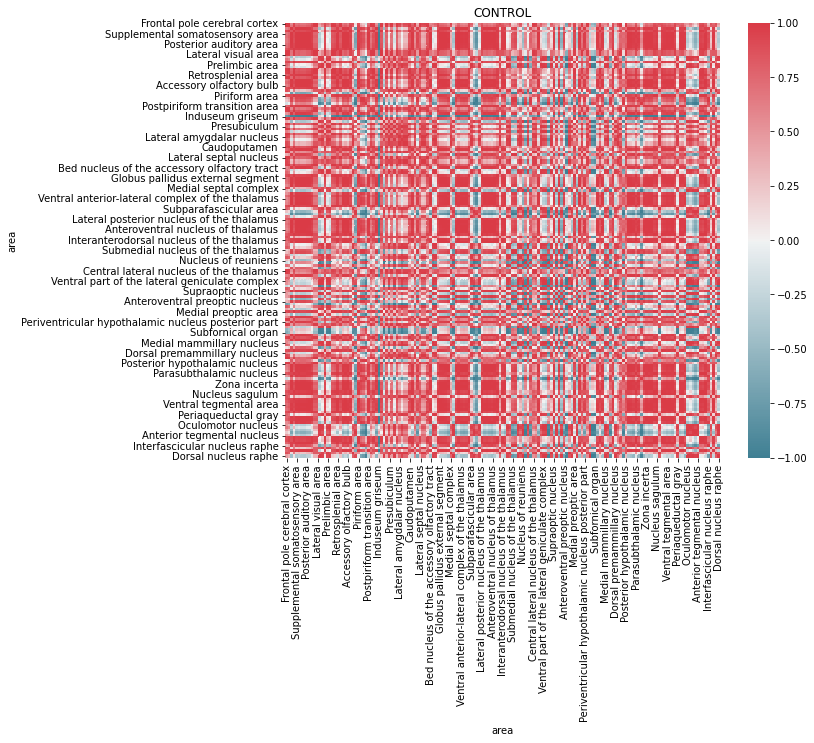

In [94]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

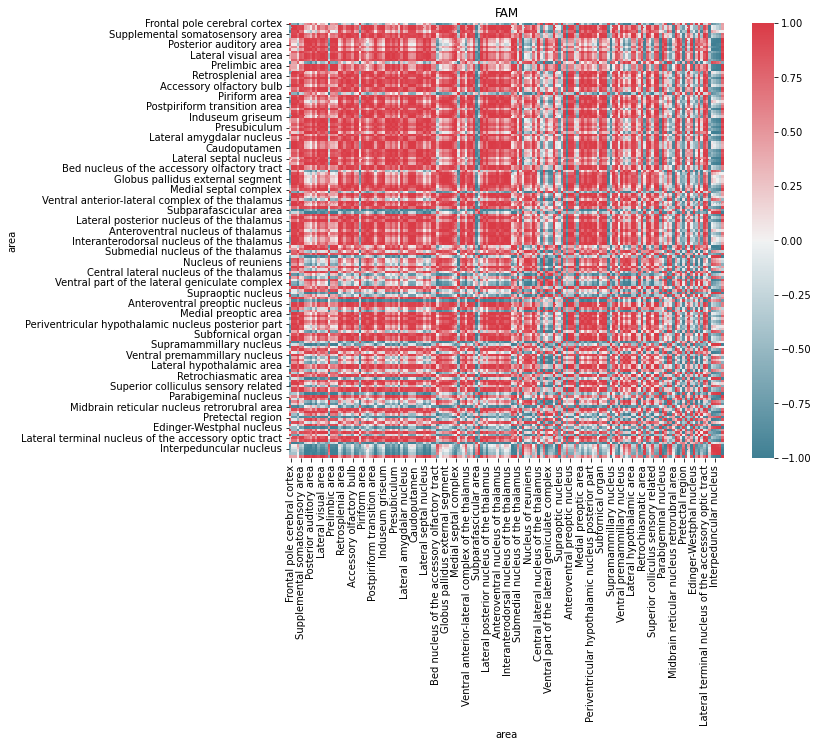

In [95]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

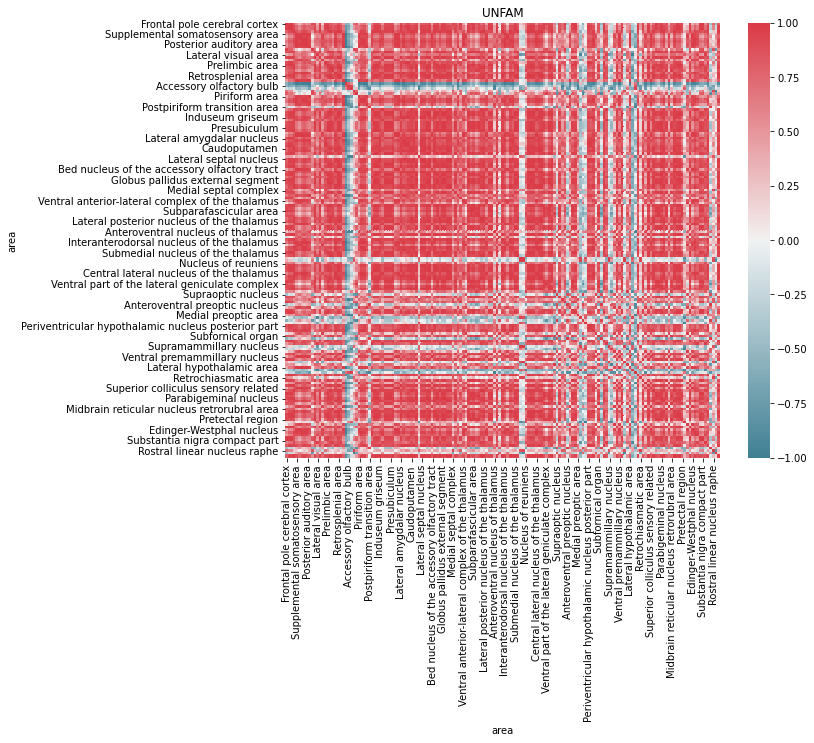

In [96]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate relative density

In [71]:
df_control_rd, df_fam_rd, df_unfam_rd = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='relative_density')

In [73]:
df_ttest_rd = ace.test_across_groups([df_control_rd,df_fam_rd,df_unfam_rd])

In [74]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [75]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Basomedial amygdalar nucleus,0.003697
Piriform area,0.010541
Piriform-amygdalar area,0.022633
Subthalamic nucleus,0.030632
Periventricular hypothalamic nucleus preoptic part,0.032596
Anterior amygdalar area,0.032949
Intercalated amygdalar nucleus,0.034312
Anterior hypothalamic nucleus,0.034487
Subparaventricular zone,0.044724


In [78]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.000451
Ventral premammillary nucleus,0.001136
Parafascicular nucleus,0.002047
Cortical amygdalar area,0.002985
Anterior hypothalamic nucleus,0.004909
Subthalamic nucleus,0.006017
Medial amygdalar nucleus,0.006879
Lateral posterior nucleus of the thalamus,0.007322
Nucleus accumbens,0.007846


In [79]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Anterior hypothalamic nucleus,0.002029
Medial septal complex,0.002236
Anterior amygdalar area,0.002314
Subparaventricular zone,0.007767
Fundus of striatum,0.014486
Periventricular hypothalamic nucleus preoptic part,0.017121
Mediodorsal nucleus of thalamus,0.01987
Anterodorsal nucleus,0.023418
Globus pallidus internal segment,0.026872
